In [3]:
## Installing packages.

#!pip install praw
#!pip install textblob
#!pip install datetime

   ---------------------------------------- 0.0/191.0 kB ? eta -:--:--
   ------------------- -------------------- 92.2/191.0 kB 2.6 MB/s eta 0:00:01
   -------------------------------------- - 184.3/191.0 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 191.0/191.0 kB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   - -------------------------------------- 30.7/626.3 kB 1.4 MB/s eta 0:00:01
   ---------- ----------------------------- 163.8/626.3 kB 3.3 MB/s eta 0:00:01
   ----------------------------- ---------- 460.8/626.3 kB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 626.3/626.3 kB 3.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/52.6 kB ? eta -:--:--
   ---------------------------------------- 52.6/52.6 kB 1.3 MB/s eta 0:00:00


In [4]:
import praw

# Setting up the reddit app.

In [5]:
## Setting up the reddit app.

reddit = praw.Reddit(
    client_id='Akdm2jaizIZg9ybVs2H5pg',
    client_secret='rw7Enp91N7_dPWlFj6KO6t3ne0staA',
    user_agent='ThesisData'
)

In [6]:
## Checking if it works and printing the titles of the top 5 posts in the "memes" subreddit.

subreddit = reddit.subreddit('memes')
for submission in subreddit.top(limit=5):
    print(submission.title)

A short story
She did her best ok?
This house ain’t big enough for the six of us
They what???
I feel privileged


# Function to fetch top memes.
Collect top memes using praw; collect a set of features and save everything to a dataframe.

In [7]:
import pandas as pd
from datetime import datetime, timezone
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os

In [8]:
# Check for meme extension to ensure consistency (e.g., no videos/GIF). Moreover, some of the upcoming functions
# and packages only work with images.
ALLOWED_EXTENSIONS = {'jpeg', 'jpg', 'png'}

def fetch_top_meme_info(subreddit_name, limit=50):
    subreddit = reddit.subreddit(subreddit_name)
    top_memes = subreddit.top(limit=None)  # Fetch all top memes

    meme_data = []
    memes_fetched = 0

    for meme in top_memes:
        # Check if the URL is from i.redd.it and ends with a permitted extension. This step is done to ensure that all
        # collected memes are indeed from reddit. Without this step, the function also fetches some memes from imgur etc.
        if meme.url.lower().startswith("https://i.redd.it/") and any(meme.url.lower().endswith(ext) for ext in ALLOWED_EXTENSIONS):
            author_name = meme.author.name if meme.author else "Unknown"
            author_karma = None
            author_comment_karma = None
            author_account_age_days = None

            if author_name != "Unknown":
                try:
                    author = reddit.redditor(author_name)
                    author_karma = author.link_karma + author.comment_karma
                    author_comment_karma = author.comment_karma
                    author_account_created_utc = author.created_utc
                    if author_account_created_utc:
                        author_account_created_utc_naive = datetime.utcfromtimestamp(author_account_created_utc)
                        current_time_utc_naive = datetime.utcnow()
                        author_account_age_days = (current_time_utc_naive - author_account_created_utc_naive).days
                except Exception as e:
                    print(f"Error fetching author info for {author_name}: {e}")

            meme_info = {
                'title': meme.title,
                'title_length': len(meme.title),  # Calculate title length
                'url': meme.url,
                'author': author_name,
                'author_karma': author_karma,
                'author_comment_karma': author_comment_karma,
                'author_account_age_days': author_account_age_days,
                'upvotes': meme.score,
                'comments': meme.num_comments,
                'post_time': datetime.utcfromtimestamp(meme.created_utc)
            }

            meme_data.append(meme_info)
            memes_fetched += 1

            # Stop fetching if we have reached the desired limit
            if memes_fetched == limit:
                break

    return pd.DataFrame(meme_data)


In [26]:
# Fetch top memes and save to a CSV file

memes_df = fetch_top_meme_info('memes', limit=400)
memes_df.to_csv('top_memes.csv', index=False)

Error fetching author info for Zlecklamar: 'Redditor' object has no attribute 'link_karma'
Error fetching author info for _Floydian: 'Redditor' object has no attribute 'link_karma'
Error fetching author info for _clickhere_: 'Redditor' object has no attribute 'link_karma'
Error fetching author info for harshvpandey101x: 'Redditor' object has no attribute 'link_karma'
Error fetching author info for BeyondFootball: 'Redditor' object has no attribute 'link_karma'
Error fetching author info for Amaan_k: 'Redditor' object has no attribute 'link_karma'
Error fetching author info for idea4granted: 'Redditor' object has no attribute 'link_karma'
Error fetching author info for idea4granted: 'Redditor' object has no attribute 'link_karma'
Error fetching author info for __Dawn__Amber__: 'Redditor' object has no attribute 'link_karma'
Error fetching author info for idea4granted: 'Redditor' object has no attribute 'link_karma'
Error fetching author info for jubu_jubu: 'Redditor' object has no attri

# Handling missing data and removing any duplicate rows.

In [9]:
# Load the data
memes_df = pd.read_csv('top_memes.csv')

# Display columns to ensure they are correct
print("Columns in the DataFrame:")
print(memes_df.columns)

# Identify duplicates
duplicates = memes_df[memes_df.duplicated()]

# Drop duplicates
memes_df = memes_df.drop_duplicates()

# Check for missing data before cleaning
print("Missing data before cleaning:")
print(memes_df.isnull().sum())

# Define the fillna dictionary
fillna_dict = {
    'author_karma': 0,
    'author_comment_karma': 0,
    'author_account_age_days': 0,
    'upvotes': 0,
    'comments': 0,
    'post_time': '1970-01-01'  # Use a placeholder date for missing post_time
}

# Ensure all columns are present in the DataFrame
for col in fillna_dict.keys():
    if col not in memes_df.columns:
        print(f"Warning: Column {col} not found in the DataFrame.")
    else:
        # Check the data type of the column and convert if necessary
        if pd.api.types.is_numeric_dtype(memes_df[col]):
            memes_df[col] = memes_df[col].astype(float)
        elif pd.api.types.is_string_dtype(memes_df[col]):
            memes_df[col] = memes_df[col].astype(str)

# Fill NaN values
memes_df_cleaned = memes_df.fillna(fillna_dict)

# Verify there are no NaN values
print("Missing data after cleaning:")
print(memes_df_cleaned.isnull().sum())

# Display the cleaned DataFrame
print(memes_df_cleaned)


Columns in the DataFrame:
Index(['title', 'title_length', 'url', 'author', 'author_karma',
       'author_comment_karma', 'author_account_age_days', 'upvotes',
       'comments', 'post_time'],
      dtype='object')
Missing data before cleaning:
title                       0
title_length                0
url                         0
author                      0
author_karma               73
author_comment_karma       73
author_account_age_days    73
upvotes                     0
comments                    0
post_time                   0
dtype: int64
Missing data after cleaning:
title                      0
title_length               0
url                        0
author                     0
author_karma               0
author_comment_karma       0
author_account_age_days    0
upvotes                    0
comments                   0
post_time                  0
dtype: int64
                                             title  title_length  \
0                                    A sho

In [28]:
# Save cleaned data to CSV
memes_df_cleaned.to_csv('top_memes_cleaned.csv', index=False)

# Collecting non-viral memes.

PRAW itself does not have built-in functionality to directly extract posts from a specific timeframe. This is because Reddit's API (which PRAW interacts with) does not support querying posts based on a specific datetime range.

To fetch posts from a specific timeframe using PRAW, we need to fetch a larger set of posts (e.g., the most recent posts) and then filter them based on their created_utc attribute, which represents the timestamp of when the post was created. To ensure that we have a big enough dataset to choose from, we will extract the most recent 100000 posts from reddit.

In [29]:
def fetch_newest_posts(subreddit_name, total_posts=100000):
    subreddit = reddit.subreddit(subreddit_name)
    posts_fetched = 0
    batch_size = 100
    all_posts = []

    print(f"Fetching newest posts from r/{subreddit_name}...")

    while posts_fetched < total_posts:
        # Fetch posts in batches of 100
        batch = subreddit.new(limit=batch_size)
        batch_posts = [post for post in batch]
        all_posts.extend(batch_posts)
        posts_fetched += len(batch_posts)
        print(f"Fetched {posts_fetched} posts so far...")

    return all_posts[:total_posts]  # Return only up to total_posts

# Function to convert UTC to Amsterdam time zone
def utc_to_amsterdam(utc_dt):
    utc = pytz.utc.localize(utc_dt)
    amsterdam_tz = pytz.timezone('Europe/Amsterdam')
    amsterdam_dt = utc.astimezone(amsterdam_tz)
    return amsterdam_dt

# Fetch the posts.
subreddit_name = 'memes'
total_posts = 100000
newest_posts = fetch_newest_posts(subreddit_name, total_posts)

# Output the total number of posts fetched
print(f"Total posts fetched: {len(newest_posts)}")


Fetching newest posts from r/memes...
Fetched 100 posts so far...
Fetched 200 posts so far...
Fetched 300 posts so far...
Fetched 400 posts so far...
Fetched 500 posts so far...
Fetched 600 posts so far...
Fetched 700 posts so far...
Fetched 800 posts so far...
Fetched 900 posts so far...
Fetched 1000 posts so far...
Fetched 1100 posts so far...
Fetched 1200 posts so far...
Fetched 1300 posts so far...
Fetched 1400 posts so far...
Fetched 1500 posts so far...
Fetched 1600 posts so far...
Fetched 1700 posts so far...
Fetched 1800 posts so far...
Fetched 1900 posts so far...
Fetched 2000 posts so far...
Fetched 2100 posts so far...
Fetched 2200 posts so far...
Fetched 2300 posts so far...
Fetched 2400 posts so far...
Fetched 2500 posts so far...
Fetched 2600 posts so far...
Fetched 2700 posts so far...
Fetched 2800 posts so far...
Fetched 2900 posts so far...
Fetched 3000 posts so far...
Fetched 3100 posts so far...
Fetched 3200 posts so far...
Fetched 3300 posts so far...
Fetched 3400 p

Fetched 27700 posts so far...
Fetched 27800 posts so far...
Fetched 27900 posts so far...
Fetched 28000 posts so far...
Fetched 28100 posts so far...
Fetched 28200 posts so far...
Fetched 28300 posts so far...
Fetched 28400 posts so far...
Fetched 28500 posts so far...
Fetched 28600 posts so far...
Fetched 28700 posts so far...
Fetched 28800 posts so far...
Fetched 28900 posts so far...
Fetched 29000 posts so far...
Fetched 29100 posts so far...
Fetched 29200 posts so far...
Fetched 29300 posts so far...
Fetched 29400 posts so far...
Fetched 29500 posts so far...
Fetched 29600 posts so far...
Fetched 29700 posts so far...
Fetched 29800 posts so far...
Fetched 29900 posts so far...
Fetched 30000 posts so far...
Fetched 30100 posts so far...
Fetched 30200 posts so far...
Fetched 30300 posts so far...
Fetched 30400 posts so far...
Fetched 30500 posts so far...
Fetched 30600 posts so far...
Fetched 30700 posts so far...
Fetched 30800 posts so far...
Fetched 30900 posts so far...
Fetched 31

Fetched 55100 posts so far...
Fetched 55200 posts so far...
Fetched 55300 posts so far...
Fetched 55400 posts so far...
Fetched 55500 posts so far...
Fetched 55600 posts so far...
Fetched 55700 posts so far...
Fetched 55800 posts so far...
Fetched 55900 posts so far...
Fetched 56000 posts so far...
Fetched 56100 posts so far...
Fetched 56200 posts so far...
Fetched 56300 posts so far...
Fetched 56400 posts so far...
Fetched 56500 posts so far...
Fetched 56600 posts so far...
Fetched 56700 posts so far...
Fetched 56800 posts so far...
Fetched 56900 posts so far...
Fetched 57000 posts so far...
Fetched 57100 posts so far...
Fetched 57200 posts so far...
Fetched 57300 posts so far...
Fetched 57400 posts so far...
Fetched 57500 posts so far...
Fetched 57600 posts so far...
Fetched 57700 posts so far...
Fetched 57800 posts so far...
Fetched 57900 posts so far...
Fetched 58000 posts so far...
Fetched 58100 posts so far...
Fetched 58200 posts so far...
Fetched 58300 posts so far...
Fetched 58

Fetched 82500 posts so far...
Fetched 82600 posts so far...
Fetched 82700 posts so far...
Fetched 82800 posts so far...
Fetched 82900 posts so far...
Fetched 83000 posts so far...
Fetched 83100 posts so far...
Fetched 83200 posts so far...
Fetched 83300 posts so far...
Fetched 83400 posts so far...
Fetched 83500 posts so far...
Fetched 83600 posts so far...
Fetched 83700 posts so far...
Fetched 83800 posts so far...
Fetched 83900 posts so far...
Fetched 84000 posts so far...
Fetched 84100 posts so far...
Fetched 84200 posts so far...
Fetched 84300 posts so far...
Fetched 84400 posts so far...
Fetched 84500 posts so far...
Fetched 84600 posts so far...
Fetched 84700 posts so far...
Fetched 84800 posts so far...
Fetched 84900 posts so far...
Fetched 85000 posts so far...
Fetched 85100 posts so far...
Fetched 85200 posts so far...
Fetched 85300 posts so far...
Fetched 85400 posts so far...
Fetched 85500 posts so far...
Fetched 85600 posts so far...
Fetched 85700 posts so far...
Fetched 85

In [44]:
# Convert to a csv file.
import csv

# Convert posts to a list of dictionaries
posts_data = []
for post in newest_posts:
    amsterdam_time = utc_to_amsterdam(datetime.utcfromtimestamp(post.created_utc))
    post_dict = {
        'title': post.title,
        'created_utc': amsterdam_time.strftime('%Y-%m-%d %H:%M:%S'),
        'score': post.score,
        'url': post.url,
        'author': post.author.name if post.author else 'N/A'
    }
    posts_data.append(post_dict)

# Save to a CSV file
csv_file = 'newest_posts.csv'
with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=posts_data[0].keys())
    writer.writeheader()
    writer.writerows(posts_data)

print(f"Saved {len(posts_data)} posts to {csv_file}")

Saved 100000 posts to newest_posts.csv


Out of those posts, 400 have been selected, with a nr of upvotes smaller than 100. This was done in Excel (because jupyter couldn't handle it), by filtering and sorting out the data. The csv will be imported below.

# Handling missing values and removing duplicate rows.

In [10]:
# Load the data
n_memes_df = pd.read_csv('non_viral_memes.csv')

# Display columns to ensure they are correct
print("Columns in the DataFrame:")
print(n_memes_df.columns)

# Identify duplicates
duplicates = n_memes_df[n_memes_df.duplicated()]

# Drop duplicates
n_memes_df = n_memes_df.drop_duplicates()

# Check for missing data before cleaning
print("Missing data before cleaning:")
print(n_memes_df.isnull().sum())

# Define the fillna dictionary
fillna_dict = {
    'author_karma': 0,
    'author_comment_karma': 0,
    'author_account_age_days': 0,
    'upvotes': 0,
    'comments': 0,
    'post_time': '1970-01-01'  # Use a placeholder date for missing post_time
}

# Ensure all columns are present in the DataFrame
for col in fillna_dict.keys():
    if col not in n_memes_df.columns:
        print(f"Warning: Column {col} not found in the DataFrame.")
    else:
        # Check the data type of the column and convert if necessary
        if pd.api.types.is_numeric_dtype(n_memes_df[col]):
            n_memes_df[col] = n_memes_df[col].astype(float)
        elif pd.api.types.is_string_dtype(n_memes_df[col]):
            n_memes_df[col] = n_memes_df[col].astype(str)

# Fill NaN values
n_memes_df_cleaned = n_memes_df.fillna(fillna_dict)

# Verify there are no NaN values
print("Missing data after cleaning:")
print(n_memes_df_cleaned.isnull().sum())

# Display the cleaned DataFrame
print(n_memes_df_cleaned.head())

# Save cleaned data to CSV
n_memes_df_cleaned.to_csv('non_viral_memes_cleaned.csv', index=False)

Columns in the DataFrame:
Index(['title', 'title_length', 'url', 'author', 'author_karma',
       'author_comment_karma', 'author_account_age_days', 'upvotes',
       'comments', 'post_time'],
      dtype='object')
Missing data before cleaning:
title                      0
title_length               0
url                        0
author                     0
author_karma               1
author_comment_karma       1
author_account_age_days    1
upvotes                    0
comments                   0
post_time                  0
dtype: int64
Missing data after cleaning:
title                      0
title_length               0
url                        0
author                     0
author_karma               0
author_comment_karma       0
author_account_age_days    0
upvotes                    0
comments                   0
post_time                  0
dtype: int64
                                               title  title_length  \
0                      After the presidential deba

# Sentiment Analysis of post title with TextBlob (viral).

In [111]:
import pandas as pd
from textblob import TextBlob

# Assuming 'top_memes_cleaned.csv' contains a 'title' column with meme titles
memes_df_cleaned = pd.read_csv('top_memes_cleaned.csv')

# Function to get the sentiment polarity and subjectivity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Function to categorize sentiment
def categorize_sentiment(polarity):
    if polarity < -0.1:
        return 'negative'
    elif polarity > 0.1:
        return 'positive'
    else:
        return 'neutral'

# Apply sentiment analysis to the 'title' column
memes_df_cleaned['title_sentiment'] = memes_df_cleaned['title'].apply(get_sentiment)

# Unpack the tuple into separate columns for polarity and subjectivity
memes_df_cleaned[['title_polarity', 'title_subjectivity']] = pd.DataFrame(memes_df_cleaned['title_sentiment'].tolist(), index=memes_df_cleaned.index)

# Categorize the sentiment based on polarity
memes_df_cleaned['sentiment_category'] = memes_df_cleaned['title_polarity'].apply(categorize_sentiment)

# Display the first few rows to verify the results
print(memes_df_cleaned[['title', 'title_polarity', 'title_subjectivity', 'sentiment_category']])

# Save the updated DataFrame back to CSV
memes_df_cleaned.to_csv('top_memes_cleaned.csv', index=False)


                                             title  title_polarity  \
0                                    A short story            0.00   
1                             She did her best ok?            0.75   
2    This house ain’t big enough for the six of us            0.00   
3                                I feel privileged            0.00   
4                              uncanny resemblance            0.00   
..                                             ...             ...   
395                                    Oh Romeo...            0.00   
396        Fuck Daniel, all my homies hate Daniel.           -0.60   
397       I guess I am a useless member of society           -0.50   
398                                        program            0.00   
399                    I feel this on a real level            0.20   

     title_subjectivity sentiment_category  
0                  0.30            neutral  
1                  0.40           positive  
2                  0.30 

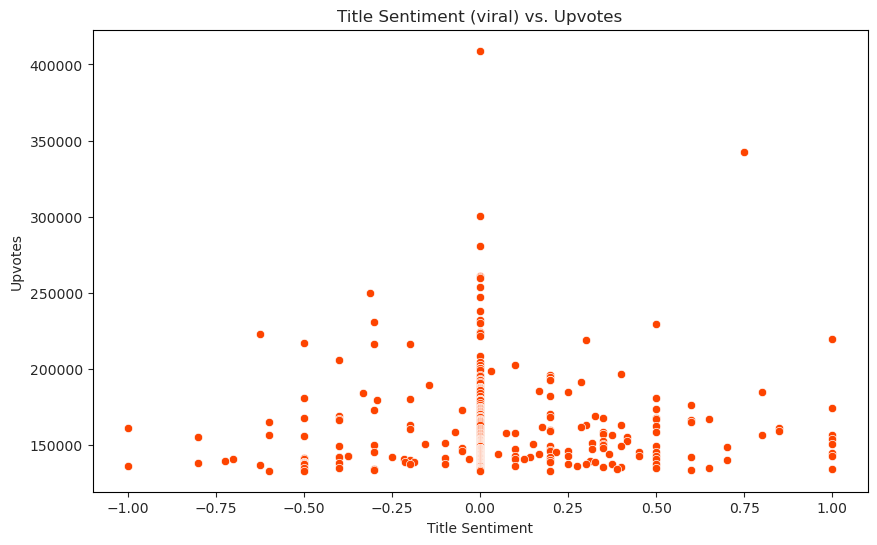

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the size as needed
fig.patch.set_facecolor('#ffffff')  # Set the figure background color

# Scatter plot of title sentiment vs. upvotes
sns.scatterplot(x='title_sentiment', y='upvotes', data=memes_df_cleaned, color='#fd4400', ax=ax)

# Customize plot elements
ax.set_title('Title Sentiment (viral) vs. Upvotes', color='#262626')
ax.set_facecolor('#ffffff')  # Set the axes background color
ax.set_xlabel('Title Sentiment', color='#262626')  # Set x-axis label color
ax.set_ylabel('Upvotes', color='#262626')  # Set y-axis label color
ax.tick_params(axis='x', colors='#262626')  # Set x-axis tick color
ax.tick_params(axis='y', colors='#262626')  # Set y-axis tick color

# Set x-axis limits with space around -1 and 1
ax.set_xlim(-1.1, 1.1)

plt.show()


## Checking for normality with histograms and QQ plots.

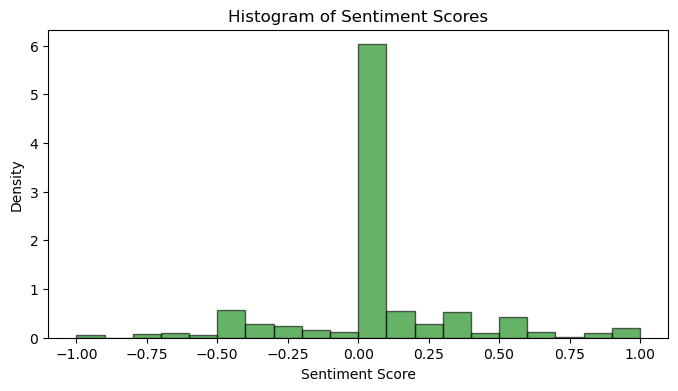

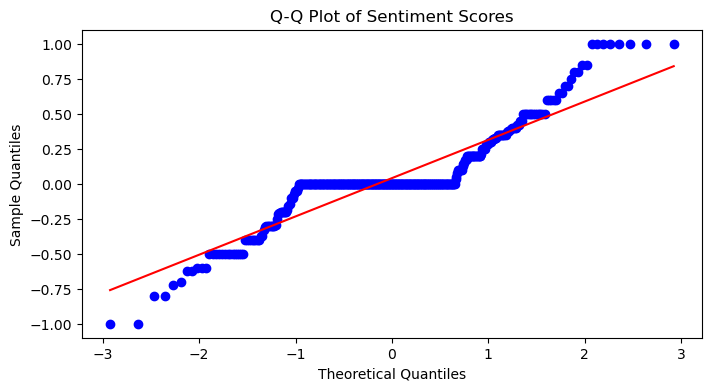

In [13]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

sentiment_scores = memes_df_cleaned['title_sentiment'].values
upvotes = memes_df_cleaned['upvotes'].values

# Plot histogram of sentiment scores
plt.figure(figsize=(8, 4))
plt.hist(sentiment_scores, bins=20, density=True, alpha=0.6, color='g', edgecolor='black')
plt.title('Histogram of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

# Q-Q plot of sentiment scores against normal distribution
plt.figure(figsize=(8, 4))
stats.probplot(sentiment_scores, dist="norm", plot=plt)
plt.title('Q-Q Plot of Sentiment Scores')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()


# Sentiment Analysis of post title with TextBlob (non-viral).

In [113]:
import pandas as pd
from textblob import TextBlob

# Assuming 'non_viral_memes_cleaned.csv' contains a 'title' column with meme titles
n_memes_df_cleaned = pd.read_csv('non_viral_memes_cleaned.csv')

# Function to get the sentiment polarity and subjectivity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Function to categorize sentiment
def categorize_sentiment(polarity):
    if polarity < -0.1:
        return 'negative'
    elif polarity > 0.1:
        return 'positive'
    else:
        return 'neutral'

# Apply sentiment analysis to the 'title' column
n_memes_df_cleaned['title_sentiment'] = n_memes_df_cleaned['title'].apply(get_sentiment)

# Unpack the tuple into separate columns for polarity and subjectivity
n_memes_df_cleaned[['title_polarity', 'title_subjectivity']] = pd.DataFrame(n_memes_df_cleaned['title_sentiment'].tolist(), index=n_memes_df_cleaned.index)

# Categorize the sentiment based on polarity
n_memes_df_cleaned['sentiment_category'] = n_memes_df_cleaned['title_polarity'].apply(categorize_sentiment)

# Display the first few rows to verify the results
print(n_memes_df_cleaned[['title', 'title_polarity', 'title_subjectivity', 'sentiment_category']])

# Save the updated DataFrame back to CSV
n_memes_df_cleaned.to_csv('non_viral_memes_cleaned.csv', index=False)


                                                 title  title_polarity  \
0                        After the presidential debate        0.000000   
1      I hope the joke doesn't fly above anyone's head        0.400000   
2    Yeah, this week... need-a cuppa... or two, or ...        0.000000   
3    The county hasn't been this united since the s...        0.000000   
4                          We have to help the boomers        0.000000   
..                                                 ...             ...   
395                       That's how catholicism works        0.000000   
396                         We Don’t Serve Droids Here        0.000000   
397  Sorry I used instagram to edit this meme, but ...       -0.107143   
398  Money🤑(tbrwy some sequels were good and others...        0.700000   
399                                Ruining any chances        0.000000   

     title_subjectivity sentiment_category  
0              0.000000            neutral  
1              0.5000

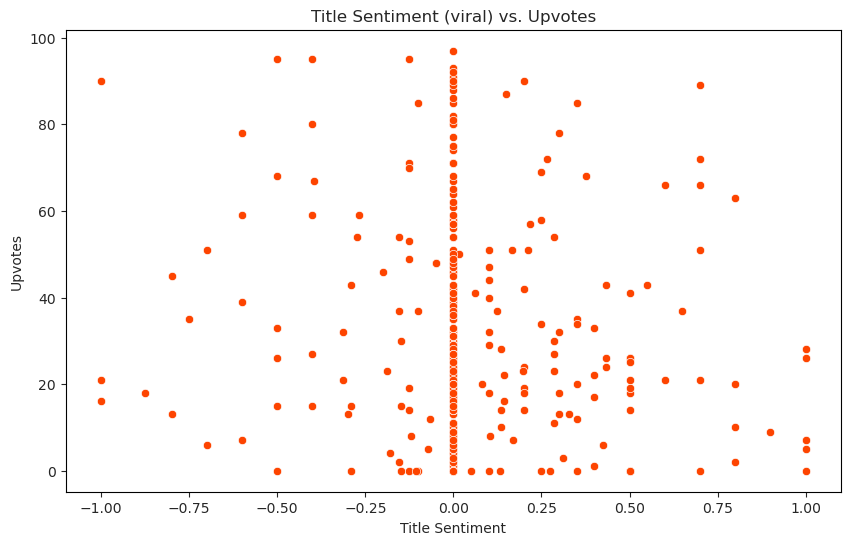

In [79]:
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the size as needed
fig.patch.set_facecolor('#ffffff')  # Set the figure background color

# Scatter plot of title sentiment vs. upvotes
sns.scatterplot(x='title_sentiment', y='upvotes', data=n_memes_df_cleaned, color='#fd4400', ax=ax)

# Customize plot elements
ax.set_title('Title Sentiment (viral) vs. Upvotes', color='#262626')
ax.set_facecolor('#ffffff')  # Set the axes background color
ax.set_xlabel('Title Sentiment', color='#262626')  # Set x-axis label color
ax.set_ylabel('Upvotes', color='#262626')  # Set y-axis label color
ax.tick_params(axis='x', colors='#262626')  # Set x-axis tick color
ax.tick_params(axis='y', colors='#262626')  # Set y-axis tick color

# Set x-axis limits with space around -1 and 1
ax.set_xlim(-1.1, 1.1)

plt.show()


## Checking for normality with histograms and QQ plots.

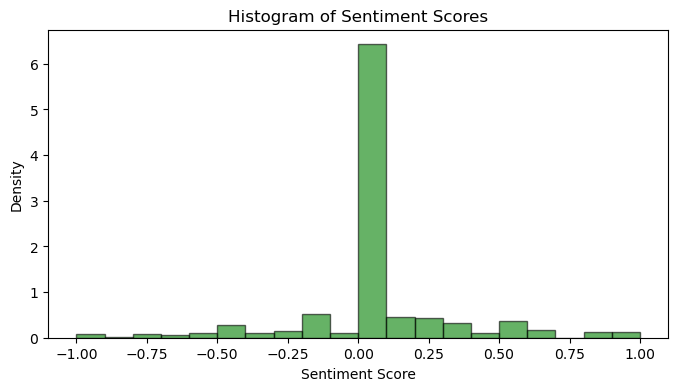

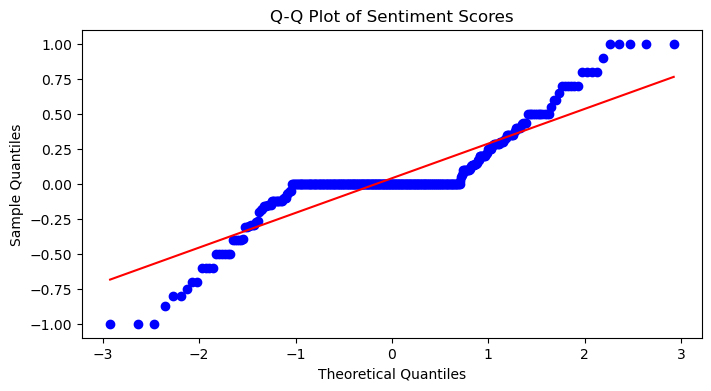

In [16]:
sentiment_scores = n_memes_df_cleaned['title_sentiment'].values
upvotes = n_memes_df_cleaned['upvotes'].values

# Plot histogram of sentiment scores
plt.figure(figsize=(8, 4))
plt.hist(sentiment_scores, bins=20, density=True, alpha=0.6, color='g', edgecolor='black')
plt.title('Histogram of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

# Q-Q plot of sentiment scores against normal distribution
plt.figure(figsize=(8, 4))
stats.probplot(sentiment_scores, dist="norm", plot=plt)
plt.title('Q-Q Plot of Sentiment Scores')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()


## Statistical Analysis of Title Sentiment and correlation with virality.

In [117]:
import pandas as pd
from textblob import TextBlob
from scipy.stats import ttest_ind, pearsonr

# Assuming 'non_viral_memes_cleaned.csv' and 'viral_memes_cleaned.csv' are the datasets
# with 'title', 'upvotes', 'title_polarity', and 'title_subjectivity' columns

# Read in both datasets
n_memes_df_cleaned = pd.read_csv('non_viral_memes_cleaned.csv')
memes_df_cleaned = pd.read_csv('top_memes_cleaned.csv')

# Function to get the sentiment polarity and subjectivity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis to the 'title' column for both datasets
n_memes_df_cleaned['title_sentiment'] = n_memes_df_cleaned['title'].apply(get_sentiment)
memes_df_cleaned['title_sentiment'] = memes_df_cleaned['title'].apply(get_sentiment)

# Unpack the tuple into separate columns for polarity and subjectivity
n_memes_df_cleaned[['title_polarity', 'title_subjectivity']] = pd.DataFrame(n_memes_df_cleaned['title_sentiment'].tolist(), index=n_memes_df_cleaned.index)
memes_df_cleaned[['title_polarity', 'title_subjectivity']] = pd.DataFrame(memes_df_cleaned['title_sentiment'].tolist(), index=memes_df_cleaned.index)

# Perform a t-test to compare the sentiment of viral and non-viral memes' titles for polarity
t_stat_polarity, p_value_polarity = ttest_ind(n_memes_df_cleaned['title_polarity'], memes_df_cleaned['title_polarity'])
print(f"T-test for Title Polarity:\n t-statistic: {t_stat_polarity}, p-value: {p_value_polarity}")

# Perform a t-test to compare the sentiment of viral and non-viral memes' titles for subjectivity
t_stat_subjectivity, p_value_subjectivity = ttest_ind(n_memes_df_cleaned['title_subjectivity'], memes_df_cleaned['title_subjectivity'])
print(f"T-test for Title Subjectivity:\n t-statistic: {t_stat_subjectivity}, p-value: {p_value_subjectivity}")

# Check for correlation between title sentiment and upvotes within each group for polarity
correlation_non_viral_polarity, p_value_non_viral_polarity = pearsonr(n_memes_df_cleaned['title_polarity'], n_memes_df_cleaned['upvotes'])
correlation_viral_polarity, p_value_viral_polarity = pearsonr(memes_df_cleaned['title_polarity'], memes_df_cleaned['upvotes'])

print(f"Pearson correlation between title polarity and upvotes for non-viral memes: {correlation_non_viral_polarity}, p-value: {p_value_non_viral_polarity}")
print(f"Pearson correlation between title polarity and upvotes for viral memes: {correlation_viral_polarity}, p-value: {p_value_viral_polarity}")

# Check for correlation between title sentiment and upvotes within each group for subjectivity
correlation_non_viral_subjectivity, p_value_non_viral_subjectivity = pearsonr(n_memes_df_cleaned['title_subjectivity'], n_memes_df_cleaned['upvotes'])
correlation_viral_subjectivity, p_value_viral_subjectivity = pearsonr(memes_df_cleaned['title_subjectivity'], memes_df_cleaned['upvotes'])

print(f"Pearson correlation between title subjectivity and upvotes for non-viral memes: {correlation_non_viral_subjectivity}, p-value: {p_value_non_viral_subjectivity}")
print(f"Pearson correlation between title subjectivity and upvotes for viral memes: {correlation_viral_subjectivity}, p-value: {p_value_viral_subjectivity}")


T-test for Title Polarity:
 t-statistic: -0.03344187086762564, p-value: 0.9733305828131831
T-test for Title Subjectivity:
 t-statistic: -0.6913675253591436, p-value: 0.48953568308899753
Pearson correlation between title polarity and upvotes for non-viral memes: -0.08433887399942212, p-value: 0.0920848759174104
Pearson correlation between title polarity and upvotes for viral memes: 0.040595547104875104, p-value: 0.418110380696414
Pearson correlation between title subjectivity and upvotes for non-viral memes: 0.10127402407529484, p-value: 0.04293424655015959
Pearson correlation between title subjectivity and upvotes for viral memes: -0.019854844944599204, p-value: 0.6921838088336155


# Title length distribution. 

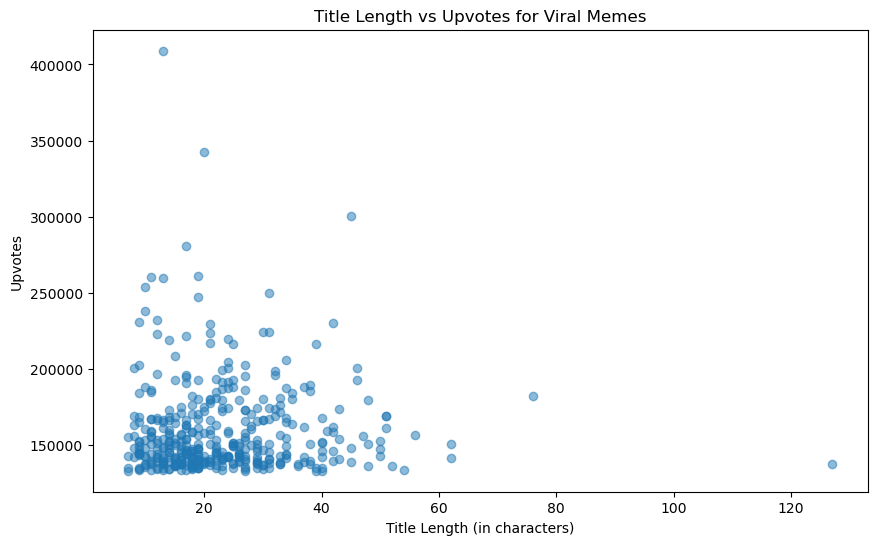

In [18]:
# Load the DataFrame for viral memes
v_memes_df_cleaned = pd.read_csv('top_memes_cleaned.csv')

# Plot title length against upvotes for viral memes
plt.figure(figsize=(10, 6))
plt.scatter(v_memes_df_cleaned['title_length'], v_memes_df_cleaned['upvotes'], alpha=0.5)
plt.title('Title Length vs Upvotes for Viral Memes')
plt.xlabel('Title Length (in characters)')
plt.ylabel('Upvotes')
plt.show()


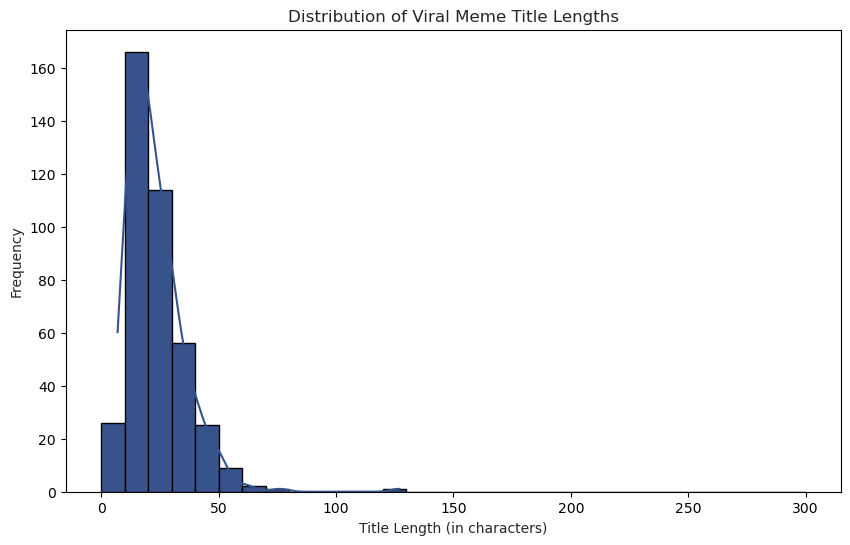

In [81]:
# Load the DataFrame
n_memes_df_cleaned = pd.read_csv('top_memes_cleaned.csv')

# Set up the plot
plt.figure(figsize=(10, 6), facecolor='#ffffff')  # Set figure background color

# Calculate the appropriate bins to cover 0 to 300 units
bins = range(0, 301, int(301 / 30))  

ax = sns.histplot(n_memes_df_cleaned['title_length'], bins=bins, kde=True, color='#37538c', alpha=1)

# Customize plot elements
ax.set_title('Distribution of Viral Meme Title Lengths', color='#262626')  # Set title color
ax.set_xlabel('Title Length (in characters)', color='#262626')  # Set x-axis label color
ax.set_ylabel('Frequency', color='#262626')  # Set y-axis label color

# Set background color of the axes
ax.set_facecolor('#ffffff')

# Show the plot
plt.show()


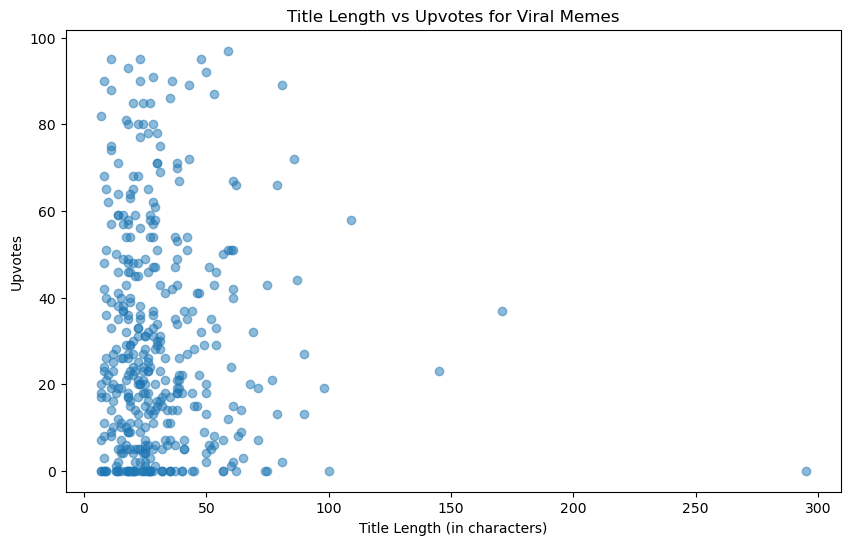

In [20]:
# Load the DataFrame for non-viral memes
nv_memes_df_cleaned = pd.read_csv('non_viral_memes_cleaned.csv')

# Plot title length against upvotes for viral memes
plt.figure(figsize=(10, 6))
plt.scatter(nv_memes_df_cleaned['title_length'], nv_memes_df_cleaned['upvotes'], alpha=0.5)
plt.title('Title Length vs Upvotes for Viral Memes')
plt.xlabel('Title Length (in characters)')
plt.ylabel('Upvotes')
plt.show()


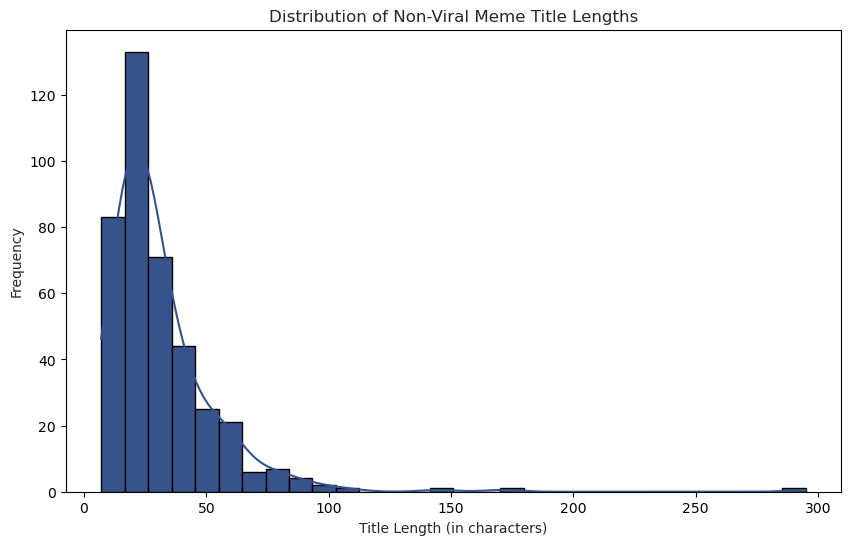

In [83]:
# Load the DataFrame
n_memes_df_cleaned = pd.read_csv('non_viral_memes_cleaned.csv')

# Set up the plot
plt.figure(figsize=(10, 6), facecolor='#ffffff')  # Set figure background color
ax = sns.histplot(n_memes_df_cleaned['title_length'], bins=30, kde=True, color='#37538c', alpha = 1)

# Customize plot elements
ax.set_title('Distribution of Non-Viral Meme Title Lengths', color='#262626')  # Set title color
ax.set_xlabel('Title Length (in characters)', color='#262626')  # Set x-axis label color
ax.set_ylabel('Frequency', color='#262626')  # Set y-axis label color

# Set background color of the axes
ax.set_facecolor('#ffffff')

# Show the plot
plt.show()


## Statistical analysis of title length and its correlation with virality.

In [22]:
# Load the datasets
memes_df_cleaned = pd.read_csv('top_memes_cleaned.csv')
n_memes_df_cleaned = pd.read_csv('non_viral_memes_cleaned.csv')

# Calculate Pearson correlation coefficient and p-value for viral memes
corr_viral, p_viral = pearsonr(memes_df_cleaned['title_length'], memes_df_cleaned['upvotes'])
print(f"Pearson correlation coefficient for viral memes: {corr_viral:.2f}, p-value: {p_viral:.4f}")

# Calculate Pearson correlation coefficient and p-value for non-viral memes
corr_non_viral, p_non_viral = pearsonr(n_memes_df_cleaned['title_length'], n_memes_df_cleaned['upvotes'])
print(f"Pearson correlation coefficient for non-viral memes: {corr_non_viral:.2f}, p-value: {p_non_viral:.4f}")


Pearson correlation coefficient for viral memes: -0.01, p-value: 0.8947
Pearson correlation coefficient for non-viral memes: -0.03, p-value: 0.5689


In [23]:
from scipy.stats import pearsonr

# Load the datasets
memes_df_cleaned = pd.read_csv('top_memes_cleaned.csv')
n_memes_df_cleaned = pd.read_csv('non_viral_memes_cleaned.csv')

memes_combined = memes_df_cleaned+n_memes_df_cleaned

# Calculate Pearson correlation coefficient and p-value
corr_viral, p_viral = pearsonr(memes_combined['title_length'], memes_combined['upvotes'])
print(f"Pearson correlation coefficient for the combined set of memes: {corr_viral:.2f}, p-value: {p_viral:.4f}")

Pearson correlation coefficient for the combined set of memes: 0.03, p-value: 0.4942


In [24]:
import statsmodels.api as sm

X = sm.add_constant(memes_df_cleaned['title_length'])
y = memes_df_cleaned['upvotes']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                upvotes   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.01754
Date:                Sat, 29 Jun 2024   Prob (F-statistic):              0.895
Time:                        19:13:45   Log-Likelihood:                -4703.7
No. Observations:                 400   AIC:                             9411.
Df Residuals:                     398   BIC:                             9419.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           1.6e+05   3316.073     48.245   

##### Conclusion: While the coefficient for title_length suggests a negative relationship (longer titles associated with fewer predicted upvotes), the high p-value indicates that this relationship is not statistically reliable in the context of this regression model. Impact Interpretation: The model indicates a negative impact of title_length on predicted upvotes, but this result is not statistically significant.

In [25]:
import statsmodels.api as sm

# Example: Simple linear regression
X = sm.add_constant(n_memes_df_cleaned['title_length'])
y = n_memes_df_cleaned['upvotes']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                upvotes   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.3250
Date:                Sat, 29 Jun 2024   Prob (F-statistic):              0.569
Time:                        19:13:48   Log-Likelihood:                -1858.8
No. Observations:                 400   AIC:                             3722.
Df Residuals:                     398   BIC:                             3730.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           29.8983      2.069     14.453   

## Testing whether there is significant difference between average title length of viral vs non-viral memes.

In [26]:
import pandas as pd
from scipy.stats import ttest_ind

# Load your data containing title lengths and virality indicators
memes_df_cleaned = pd.read_csv('top_memes_cleaned.csv')
n_memes_df_cleaned = pd.read_csv('non_viral_memes_cleaned.csv')

# Subset the data by virality
title_length_viral = memes_df_cleaned['title_length']
title_length_non_viral = n_memes_df_cleaned['title_length']

# Calculate mean title lengths
mean_title_length_viral = title_length_viral.mean()
mean_title_length_non_viral = title_length_non_viral.mean()

print(f"Mean Title Length for Viral Memes: {mean_title_length_viral:.2f}")
print(f"Mean Title Length for Non-Viral Memes: {mean_title_length_non_viral:.2f}")

# Perform two-sample t-test to compare title lengths
t_statistic, p_value = ttest_ind(title_length_viral, title_length_non_viral, equal_var=False)

print(f"Two-Sample T-test results:")
print(f"T-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in title lengths between viral and non-viral memes.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in title lengths between viral and non-viral memes.")


Mean Title Length for Viral Memes: 23.07
Mean Title Length for Non-Viral Memes: 31.19
Two-Sample T-test results:
T-statistic: -6.00
P-value: 0.0000
Reject the null hypothesis: There is a significant difference in title lengths between viral and non-viral memes.


## Testing whether there is significant difference between the two groups (on a set of features): 'author_karma', 'author_comment_karma', 'author_account_age_days', 'comments'

In [27]:
# Load the datasets
non_viral_memes = pd.read_csv('non_viral_memes_cleaned.csv')
top_memes = pd.read_csv('top_memes_cleaned.csv')

# Ensure data types are appropriate for numerical features
numerical_features = ['author_karma', 'author_comment_karma', 'author_account_age_days', 'comments']
for feature in numerical_features:
    non_viral_memes[feature] = pd.to_numeric(non_viral_memes[feature], errors='coerce')
    top_memes[feature] = pd.to_numeric(top_memes[feature], errors='coerce')

# Initialize a list to store results
results = []

# Perform t-tests and calculate Pearson correlations for each numerical feature
for feature in numerical_features:
    # Compute means
    non_viral_mean = non_viral_memes[feature].mean()
    top_memes_mean = top_memes[feature].mean()
    
    # Perform t-test
    t_stat, p_value_ttest = ttest_ind(non_viral_memes[feature], top_memes[feature], equal_var=False)
    
    # Calculate Pearson correlation
    non_viral_corr, non_viral_p = pearsonr(non_viral_memes[feature], non_viral_memes['upvotes'])
    top_memes_corr, top_memes_p = pearsonr(top_memes[feature], top_memes['upvotes'])
    
    # Store results
    results.append({
        'Feature': feature,
        'Non-viral Mean': non_viral_mean,
        'Viral Mean': top_memes_mean,
        'T-statistic': t_stat,
        'T-test P-value': p_value_ttest,
        'Non-viral Pearson correlation': non_viral_corr,
        'Non-viral Pearson P-value': non_viral_p,
        'Viral Pearson correlation': top_memes_corr,
        'Viral Pearson P-value': top_memes_p
    })

# Print results and conclusions
for result in results:
    print(f"Feature: {result['Feature']}")
    print(f"Non-viral Mean: {result['Non-viral Mean']}")
    print(f"Viral Mean: {result['Viral Mean']}")
    print(f"T-test - T-statistic: {result['T-statistic']}, P-value: {result['T-test P-value']}")
    print(f"Non-viral memes - Pearson correlation: {result['Non-viral Pearson correlation']}, P-value: {result['Non-viral Pearson P-value']}")
    print(f"Viral memes - Pearson correlation: {result['Viral Pearson correlation']}, P-value: {result['Viral Pearson P-value']}")
    
    # Determine statistical significance for t-test
    if result['T-test P-value'] < 0.05:
        print("Conclusion: There is a statistically significant difference.")
    else:
        print("Conclusion: There is no statistically significant difference.")
    
    print()


Feature: author_karma
Non-viral Mean: 236933.3525
Viral Mean: 289589.475
T-test - T-statistic: -0.6678025394537471, P-value: 0.5045305185777844
Non-viral memes - Pearson correlation: -0.09801935691400092, P-value: 0.05011610213853448
Viral memes - Pearson correlation: 0.013642437411842734, P-value: 0.7856162320665805
Conclusion: There is no statistically significant difference.

Feature: author_comment_karma
Non-viral Mean: 24816.7925
Viral Mean: 31126.2025
T-test - T-statistic: -1.1014215880882403, P-value: 0.27105629477164134
Non-viral memes - Pearson correlation: -0.06979076179374469, P-value: 0.16357557995382055
Viral memes - Pearson correlation: -0.0024963341261808394, P-value: 0.9603052637039896
Conclusion: There is no statistically significant difference.

Feature: author_account_age_days
Non-viral Mean: 1169.0375
Viral Mean: 1549.85
T-test - T-statistic: -5.985567189263199, P-value: 3.274759795456984e-09
Non-viral memes - Pearson correlation: 0.02653631870233541, P-value: 0.596

# OCR for viral memes.

In [30]:
# !pip install pytesseract pillow

import pytesseract
from PIL import Image

# Set the path to tesseract executable
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR'


In [31]:
import pandas as pd
import pytesseract
from PIL import Image
import requests
from io import BytesIO
import os

# Set the path to the Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Function to fetch an image from a URL and convert it to a PIL Image
def fetch_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        img = Image.open(BytesIO(response.content))
        return img
    except requests.exceptions.RequestException as e:
        print(f"Error fetching image from {url}: {e}")
    except Exception as e:
        print(f"Error opening image from {url}: {e}")
    return None

# Function to extract text from a PIL Image object
def extract_text_from_image(image):
    try:
        text = pytesseract.image_to_string(image)
        return text
    except Exception as e:
        print(f"Error processing image: {e}")
        return ""

# Load your existing DataFrame
memes_df_cleaned = pd.read_csv('top_memes_cleaned.csv')

# Fetch images and apply OCR to extract text from images
def extract_text_from_url(url):
    image = fetch_image_from_url(url)
    if image:
        return extract_text_from_image(image)
    return ""

memes_df_cleaned['image_text'] = memes_df_cleaned['url'].apply(extract_text_from_url)

# Display the DataFrame to verify the extracted text
print(memes_df_cleaned[['title', 'image_text']])

# Save the DataFrame as a CSV file
memes_df_cleaned.to_csv('top_memes_cleaned.csv', index=False)


                                             title  \
0                                    A short story   
1                             She did her best ok?   
2    This house ain’t big enough for the six of us   
3                                I feel privileged   
4                              uncanny resemblance   
..                                             ...   
395                                    Oh Romeo...   
396        Fuck Daniel, all my homies hate Daniel.   
397       I guess I am a useless member of society   
398                                        program   
399                    I feel this on a real level   

                                            image_text  
0    1:38\n15:04\n\n©\n' 12:17\n\nTop proof that we...  
1    Teacher hypes up class party all year\n\nThe P...  
2    News > World > Europe\n\nCoronavirus: Austria ...  
3    me 12 hours ahead in\nAsia knowing the electio...  
4    the sun\n\nprettycooltim\n\n— fi —\nee “\n\npa...  
..       

# OCR for non-viral memes.

In [32]:
# Set the path to the Tesseract executable
# Update this path to where Tesseract is installed on your system
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Function to fetch an image from a URL and convert it to a PIL Image
def fetch_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        img = Image.open(BytesIO(response.content))
        return img
    except requests.exceptions.RequestException as e:
        print(f"Error fetching image from {url}: {e}")
    except Exception as e:
        print(f"Error opening image from {url}: {e}")
    return None

# Function to extract text from a PIL Image object
def extract_text_from_image(image):
    try:
        text = pytesseract.image_to_string(image)
        return text
    except Exception as e:
        print(f"Error processing image: {e}")
        return ""

# Load your existing DataFrame
n_memes_df_cleaned = pd.read_csv('non_viral_memes_cleaned.csv')

# Fetch images and apply OCR to extract text from images
def extract_text_from_url(url):
    image = fetch_image_from_url(url)
    if image:
        return extract_text_from_image(image)
    return ""

n_memes_df_cleaned['image_text'] = n_memes_df_cleaned['url'].apply(extract_text_from_url)

# Display the DataFrame to verify the extracted text
print(n_memes_df_cleaned[['title', 'image_text']])

# Save the DataFrame as a CSV file
n_memes_df_cleaned.to_csv('non_viral_memes_cleaned.csv', index=False)


Error fetching image from https://i.redd.it/2c1mud8a5c9d1.jpeg: 404 Client Error: Not Found for url: https://i.redd.it/2c1mud8a5c9d1.jpeg
Error fetching image from https://i.redd.it/du6lpu5trb9d1.jpeg: 404 Client Error: Not Found for url: https://i.redd.it/du6lpu5trb9d1.jpeg
Error fetching image from https://i.redd.it/5z5e54ihfb9d1.jpeg: 404 Client Error: Not Found for url: https://i.redd.it/5z5e54ihfb9d1.jpeg
Error fetching image from https://i.redd.it/sn339ovg699d1.jpeg: 404 Client Error: Not Found for url: https://i.redd.it/sn339ovg699d1.jpeg
Error fetching image from https://i.redd.it/n7kiu0ze099d1.png: 404 Client Error: Not Found for url: https://i.redd.it/n7kiu0ze099d1.png
Error fetching image from https://i.redd.it/dborj8fzp89d1.jpeg: 404 Client Error: Not Found for url: https://i.redd.it/dborj8fzp89d1.jpeg
Error fetching image from https://i.redd.it/la3gayxsd89d1.jpeg: 404 Client Error: Not Found for url: https://i.redd.it/la3gayxsd89d1.jpeg
Error fetching image from https://i.

## Testing whether there is a difference between viral/non-viral memes' text length.

In [33]:
# Load the datasets
non_viral_memes = pd.read_csv('non_viral_memes_cleaned.csv')
top_memes = pd.read_csv('top_memes_cleaned.csv')

# Ensure that the text column exists and calculate text length
non_viral_memes['text_length'] = non_viral_memes['image_text'].apply(lambda x: len(str(x)))
top_memes['text_length'] = top_memes['image_text'].apply(lambda x: len(str(x)))

# Save the updated dataframes back to CSV files
non_viral_memes.to_csv('non_viral_memes_cleaned.csv', index=False)
top_memes.to_csv('top_memes_cleaned.csv', index=False)

# Perform a t-test to compare the mean text lengths
t_stat, p_value = ttest_ind(non_viral_memes['text_length'], top_memes['text_length'], equal_var=False)  # assuming unequal variances
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Calculate Pearson correlation coefficient for each group
non_viral_corr, non_viral_p = pearsonr(non_viral_memes['text_length'], non_viral_memes['upvotes'])
top_memes_corr, top_memes_p = pearsonr(top_memes['text_length'], top_memes['upvotes'])

print(f"Non-viral memes - Pearson correlation: {non_viral_corr}, P-value: {non_viral_p}")
print(f"Viral memes - Pearson correlation: {top_memes_corr}, P-value: {top_memes_p}")


T-statistic: -2.0551206607314905, P-value: 0.04023426073846549
Non-viral memes - Pearson correlation: 0.007541724696314115, P-value: 0.8804769724480928
Viral memes - Pearson correlation: 0.11724695432188886, P-value: 0.018991573431103654


In [34]:
# Load the datasets
memes_df_cleaned = pd.read_csv('top_memes_cleaned.csv')
n_memes_df_cleaned = pd.read_csv('non_viral_memes_cleaned.csv')

memes_combined = memes_df_cleaned+n_memes_df_cleaned

# Calculate Pearson correlation coefficient and p-value
corr_viral, p_viral = pearsonr(memes_combined['text_length'], memes_combined['upvotes'])
print(f"Pearson correlation coefficient for the combined set of memes: {corr_viral:.2f}, p-value: {p_viral:.4f}")

Pearson correlation coefficient for the combined set of memes: 0.02, p-value: 0.6850


# Extracting sentiment polarity and subjectivity.

In [35]:
# Load the CSV files
viral_memes_df = pd.read_csv('top_memes_cleaned.csv')
non_viral_memes_df = pd.read_csv('non_viral_memes_cleaned.csv')

# Fill NaN values in the 'image_text' column with an empty string and ensure all values are strings
viral_memes_df['image_text'] = viral_memes_df['image_text'].fillna('').astype(str)
non_viral_memes_df['image_text'] = non_viral_memes_df['image_text'].fillna('').astype(str)

# Function to get sentiment polarity and subjectivity
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

# Apply sentiment analysis to viral memes
viral_memes_df['polarity'], viral_memes_df['subjectivity'] = zip(*viral_memes_df['image_text'].apply(get_sentiment))

# Apply sentiment analysis to non-viral memes
non_viral_memes_df['polarity'], non_viral_memes_df['subjectivity'] = zip(*non_viral_memes_df['image_text'].apply(get_sentiment))

# Save the updated DataFrames to new CSV files
viral_memes_df.to_csv('top_memes_cleaned.csv', index=False)
non_viral_memes_df.to_csv('non_viral_memes_cleaned.csv', index=False)

# Display the first few rows of the updated DataFrames to verify the results
print(viral_memes_df.head())
print(non_viral_memes_df.head())


                                           title  title_length  \
0                                  A short story            13   
1                           She did her best ok?            20   
2  This house ain’t big enough for the six of us            45   
3                              I feel privileged            17   
4                            uncanny resemblance            19   

                                   url             author  author_karma  \
0  https://i.redd.it/70zdjiilli351.jpg        rextraneous       21270.0   
1  https://i.redd.it/g4vm7de3q4j51.jpg        BlackAdder7      172660.0   
2  https://i.redd.it/x4s2e60m7vm41.jpg  theonlymexicanman      584636.0   
3  https://i.redd.it/ttfhavjmd1x51.png             blityc       85698.0   
4  https://i.redd.it/cul580390k661.jpg      PrettyCoolTim      735572.0   

   author_comment_karma  author_account_age_days   upvotes  comments  \
0                6374.0                   1521.0  409043.0    4304.0   
1       

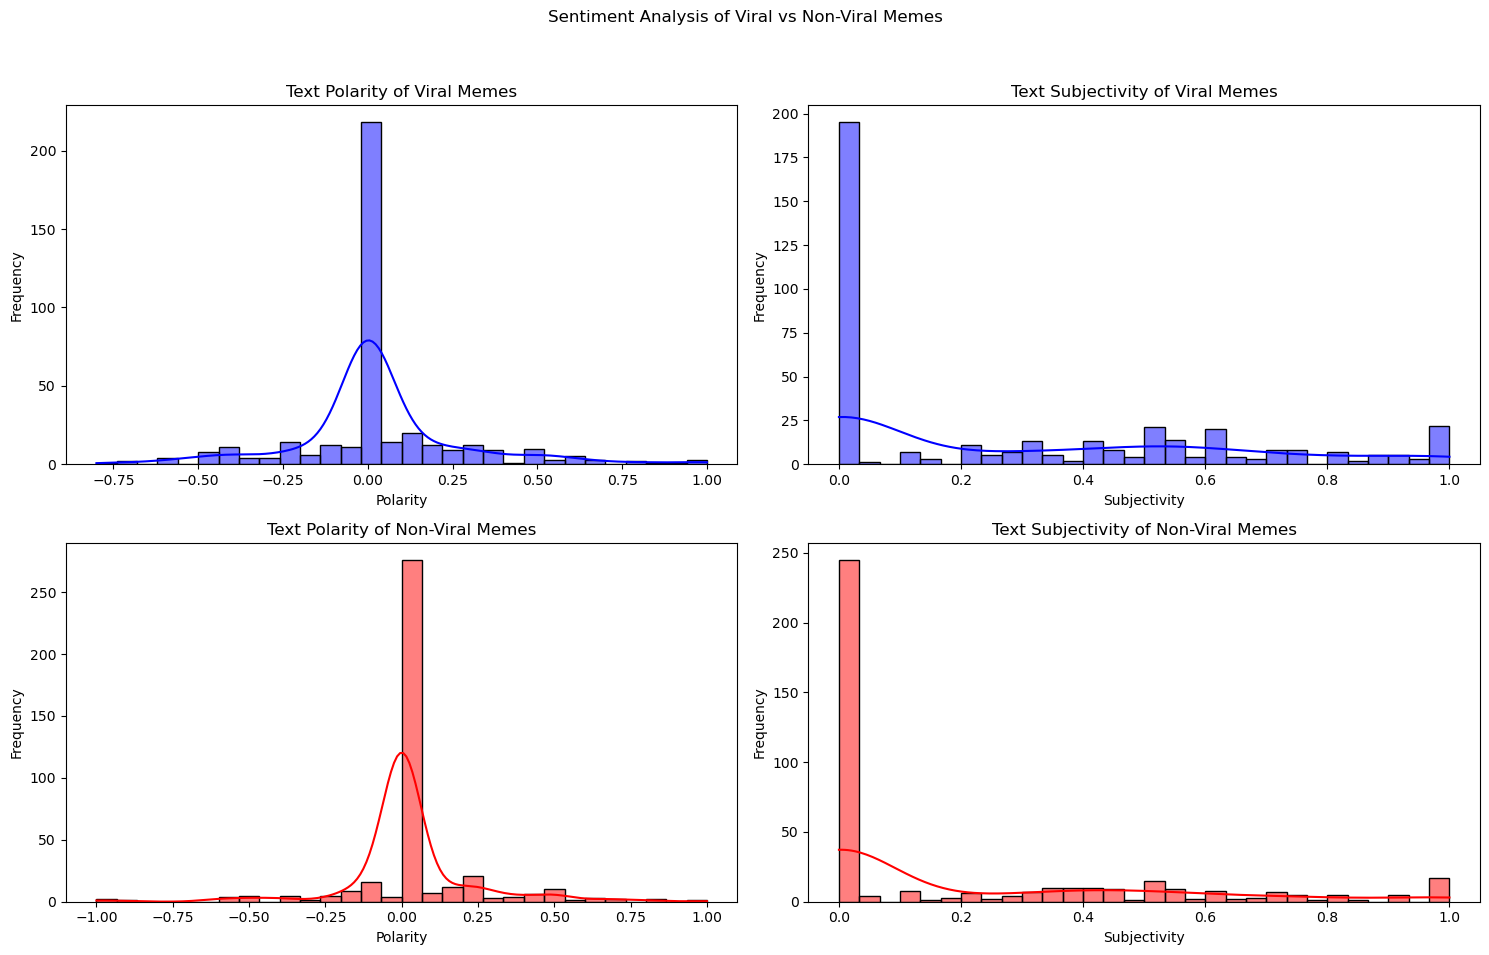

In [36]:
# Load the CSV files with sentiment analysis results
viral_memes_df = pd.read_csv('top_memes_cleaned.csv')
non_viral_memes_df = pd.read_csv('non_viral_memes_cleaned.csv')

# Define the number of bins
num_bins = 30

# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Sentiment Analysis of Viral vs Non-Viral Memes')

# Plot polarity for viral memes
sns.histplot(viral_memes_df['polarity'], bins=num_bins, kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Text Polarity of Viral Memes')
axes[0, 0].set_xlabel('Polarity')
axes[0, 0].set_ylabel('Frequency')

# Plot subjectivity for viral memes
sns.histplot(viral_memes_df['subjectivity'], bins=num_bins, kde=True, ax=axes[0, 1], color='blue')
axes[0, 1].set_title('Text Subjectivity of Viral Memes')
axes[0, 1].set_xlabel('Subjectivity')
axes[0, 1].set_ylabel('Frequency')

# Plot polarity for non-viral memes
sns.histplot(non_viral_memes_df['polarity'], bins=num_bins, kde=True, ax=axes[1, 0], color='red')
axes[1, 0].set_title('Text Polarity of Non-Viral Memes')
axes[1, 0].set_xlabel('Polarity')
axes[1, 0].set_ylabel('Frequency')

# Plot subjectivity for non-viral memes
sns.histplot(non_viral_memes_df['subjectivity'], bins=num_bins, kde=True, ax=axes[1, 1], color='red')
axes[1, 1].set_title('Text Subjectivity of Non-Viral Memes')
axes[1, 1].set_xlabel('Subjectivity')
axes[1, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()


In [37]:
# Calculate descriptive statistics for viral memes
viral_polarity_stats = viral_memes_df['polarity'].describe()
viral_subjectivity_stats = viral_memes_df['subjectivity'].describe()

# Calculate descriptive statistics for non-viral memes
non_viral_polarity_stats = non_viral_memes_df['polarity'].describe()
non_viral_subjectivity_stats = non_viral_memes_df['subjectivity'].describe()

# Print the statistics
print("Viral Memes - Polarity Statistics:\n", viral_polarity_stats)
print("\nViral Memes - Subjectivity Statistics:\n", viral_subjectivity_stats)
print("\nNon-Viral Memes - Polarity Statistics:\n", non_viral_polarity_stats)
print("\nNon-Viral Memes - Subjectivity Statistics:\n", non_viral_subjectivity_stats)


from scipy.stats import ttest_ind

# Perform t-test for polarity
polarity_ttest = ttest_ind(viral_memes_df['polarity'].dropna(), non_viral_memes_df['polarity'].dropna())

# Perform t-test for subjectivity
subjectivity_ttest = ttest_ind(viral_memes_df['subjectivity'].dropna(), non_viral_memes_df['subjectivity'].dropna())

print("T-test for Polarity:\n", polarity_ttest)
print("\nT-test for Subjectivity:\n", subjectivity_ttest)


from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test for polarity
polarity_mannwhitney = mannwhitneyu(viral_memes_df['polarity'].dropna(), non_viral_memes_df['polarity'].dropna())

# Perform Mann-Whitney U test for subjectivity
subjectivity_mannwhitney = mannwhitneyu(viral_memes_df['subjectivity'].dropna(), non_viral_memes_df['subjectivity'].dropna())

print("Mann-Whitney U Test for Polarity:\n", polarity_mannwhitney)
print("\nMann-Whitney U Test for Subjectivity:\n", subjectivity_mannwhitney)


Viral Memes - Polarity Statistics:
 count    400.000000
mean       0.029981
std        0.248971
min       -0.800000
25%        0.000000
50%        0.000000
75%        0.054762
max        1.000000
Name: polarity, dtype: float64

Viral Memes - Subjectivity Statistics:
 count    400.000000
mean       0.284491
std        0.331715
min        0.000000
25%        0.000000
50%        0.100000
75%        0.540417
max        1.000000
Name: subjectivity, dtype: float64

Non-Viral Memes - Polarity Statistics:
 count    400.000000
mean       0.023904
std        0.209377
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: polarity, dtype: float64

Non-Viral Memes - Subjectivity Statistics:
 count    400.000000
mean       0.200599
std        0.299961
min        0.000000
25%        0.000000
50%        0.000000
75%        0.400000
max        1.000000
Name: subjectivity, dtype: float64
T-test for Polarity:
 TtestResult(statistic=0.373625623997896, pv

Pearson correlation coefficient for viral memes: -0.03
Pearson correlation coefficient for non-viral memes: 0.04


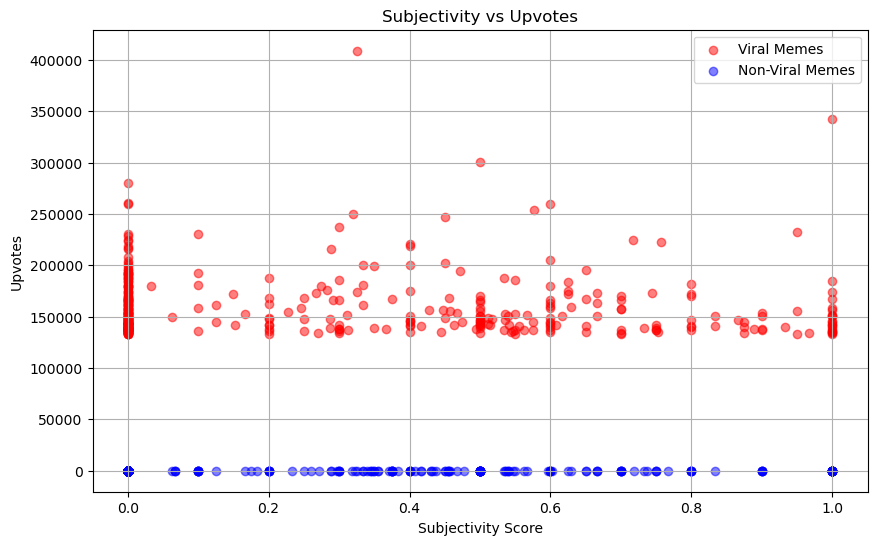

In [38]:
# Load the datasets
viral_memes_df = pd.read_csv('top_memes_cleaned.csv')
non_viral_memes_df = pd.read_csv('non_viral_memes_cleaned.csv')

# Calculate Pearson correlation coefficient and p-value for viral memes
corr_viral, _ = pearsonr(viral_memes_df['subjectivity'], viral_memes_df['upvotes'])
print(f"Pearson correlation coefficient for viral memes: {corr_viral:.2f}")

# Calculate Pearson correlation coefficient and p-value for non-viral memes
corr_non_viral, _ = pearsonr(non_viral_memes_df['subjectivity'], non_viral_memes_df['upvotes'])
print(f"Pearson correlation coefficient for non-viral memes: {corr_non_viral:.2f}")

# Plotting the relationship 
plt.figure(figsize=(10, 6))
plt.scatter(viral_memes_df['subjectivity'], viral_memes_df['upvotes'], color='red', alpha=0.5, label='Viral Memes')
plt.scatter(non_viral_memes_df['subjectivity'], non_viral_memes_df['upvotes'], color='blue', alpha=0.5, label='Non-Viral Memes')
plt.title('Subjectivity vs Upvotes')
plt.xlabel('Subjectivity Score')
plt.ylabel('Upvotes')
plt.legend()
plt.grid(True)
plt.show()


In [43]:
#!pip install transformers
#!pip install torch

In [86]:
# !pip install tf-keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.7 MB 1.7 MB/s eta 0:00:01
   ---- ----------------------------------- 0.2/1.7 MB 2.0 MB/s eta 0:00:01
   -------- ------------------------------- 0.4/1.7 MB 2.3 MB/s eta 0:00:01
   ---------- ----------------------------- 0.5/1.7 MB 2.4 MB/s eta 0:00:01
   ------------ --------------------------- 0.5/1.7 MB 2.1 MB/s eta 0:00:01
   ------------- -------------------------- 0.6/1.7 MB 2.0 MB/s eta 0:00:01
   ------------------------ --------------- 1.1/1.7 MB 3.1 MB/s eta 0:00:01
   ----------------------------- ---------- 1.3/1.7 MB 3.2 MB/s eta 0:00:01
   ------------------------------------ --- 1.6/1.7 MB 3.6 MB/s eta 0:00:01
   ------------------------------------ --- 1.6/1.7 MB 3.5 MB/s eta 0:00:01
   ------------------------------------- -- 1.6/1.7 MB 3.0 MB/s eta 0:00:01
   -----------------------

# Emotion Distribution

In [87]:
import pandas as pd
from transformers import pipeline

# Initialize the emotion classifier pipeline
classifier = pipeline('sentiment-analysis', model='bhadresh-savani/distilbert-base-uncased-emotion')

# Load the DataFrames for non-viral and viral memes
n_memes_df_cleaned = pd.read_csv('non_viral_memes_cleaned.csv')
v_memes_df_cleaned = pd.read_csv('top_memes_cleaned.csv')

# Function to classify emotion
def classify_emotion(text):
    if isinstance(text, str) and text.strip() != '':
        return classifier(text)[0]
    return {'label': 'none', 'score': 0.0}

# Apply the emotion classification to the title and image_text columns
n_memes_df_cleaned['title_emotion'] = n_memes_df_cleaned['title'].apply(lambda x: classify_emotion(x)['label'])
n_memes_df_cleaned['image_emotion'] = n_memes_df_cleaned['image_text'].apply(lambda x: classify_emotion(x)['label'])

v_memes_df_cleaned['title_emotion'] = v_memes_df_cleaned['title'].apply(lambda x: classify_emotion(x)['label'])
v_memes_df_cleaned['image_emotion'] = v_memes_df_cleaned['image_text'].apply(lambda x: classify_emotion(x)['label'])

# Save the DataFrames with emotion labels
n_memes_df_cleaned.to_csv('non_viral_memes_cleaned.csv', index=False)
v_memes_df_cleaned.to_csv('top_memes_cleaned.csv', index=False)

# Analyze the distribution of emotions
n_title_emotion_dist = n_memes_df_cleaned['title_emotion'].value_counts(normalize=True)
v_title_emotion_dist = v_memes_df_cleaned['title_emotion'].value_counts(normalize=True)

n_image_emotion_dist = n_memes_df_cleaned['image_emotion'].value_counts(normalize=True)
v_image_emotion_dist = v_memes_df_cleaned['image_emotion'].value_counts(normalize=True)

print("Non-viral Memes Title Emotion Distribution:")
print(n_title_emotion_dist)

print("\nViral Memes Title Emotion Distribution:")
print(v_title_emotion_dist)

print("\nNon-viral Memes Text Emotion Distribution:")
print(n_image_emotion_dist)

print("\nViral Memes Text Emotion Distribution:")
print(v_image_emotion_dist)



Non-viral Memes Title Emotion Distribution:
title_emotion
anger       0.4650
joy         0.3975
sadness     0.0675
fear        0.0550
love        0.0100
surprise    0.0050
Name: proportion, dtype: float64

Viral Memes Title Emotion Distribution:
title_emotion
joy         0.4325
anger       0.4125
sadness     0.0775
fear        0.0575
surprise    0.0125
love        0.0075
Name: proportion, dtype: float64

Non-viral Memes Text Emotion Distribution:
image_emotion
anger       0.3175
joy         0.3000
none        0.2375
sadness     0.0725
fear        0.0575
love        0.0125
surprise    0.0025
Name: proportion, dtype: float64

Viral Memes Text Emotion Distribution:
image_emotion
anger      0.3525
joy        0.3475
none       0.1125
fear       0.1025
sadness    0.0750
love       0.0100
Name: proportion, dtype: float64


In [101]:
import pandas as pd
from scipy.stats import chi2_contingency, pearsonr
from tabulate import tabulate

# Function to perform chi-square test and check significance
def chi_square_test(contingency_table, description):
    chi2, p, _, _ = chi2_contingency(contingency_table)
    significant = p < 0.05
    return {
        'Description': description,
        'Chi-Square': round(chi2, 3),
        'p-value': round(p, 3),
        'Significant': significant
    }

# Prepare contingency tables
title_emotion_contingency = pd.crosstab(n_memes_df_cleaned['title_emotion'], v_memes_df_cleaned['title_emotion'])
image_emotion_contingency = pd.crosstab(n_memes_df_cleaned['image_emotion'], v_memes_df_cleaned['image_emotion'])

# Perform chi-square tests and store results
chi_square_results = []
chi_square_results.append(chi_square_test(title_emotion_contingency, "Title Emotions"))
chi_square_results.append(chi_square_test(image_emotion_contingency, "Image Emotions"))

# Convert chi-square results to DataFrame
chi_square_df = pd.DataFrame(chi_square_results)

# Print chi-square results in table format
print("Chi-Square Test Results")
print(tabulate(chi_square_df, headers='keys', tablefmt='psql', showindex=False))

# Function to perform Pearson correlation and check significance
def correlation_test(upvotes, indices, description):
    if len(upvotes) > 1:  # Pearson correlation requires at least two data points
        corr, p = pearsonr(upvotes, indices)
        significant = p < 0.05
        return {
            'Description': description,
            'Correlation': round(corr, 3),
            'p-value': round(p, 3),
            'Significant': significant
        }
    else:
        return {
            'Description': description,
            'Correlation': None,
            'p-value': None,
            'Significant': False
        }

# Perform correlation tests and store results
correlation_results = []

# Title emotions correlation
for emotion in n_memes_df_cleaned['title_emotion'].unique():
    n_emotion_upvotes = n_memes_df_cleaned[n_memes_df_cleaned['title_emotion'] == emotion]['upvotes']
    v_emotion_upvotes = v_memes_df_cleaned[v_memes_df_cleaned['title_emotion'] == emotion]['upvotes']
    correlation_results.append(correlation_test(n_emotion_upvotes, range(len(n_emotion_upvotes)), f"Non-viral Memes with Title Emotion '{emotion}'"))
    correlation_results.append(correlation_test(v_emotion_upvotes, range(len(v_emotion_upvotes)), f"Viral Memes with Title Emotion '{emotion}'"))

# Image emotions correlation
for emotion in n_memes_df_cleaned['image_emotion'].unique():
    n_emotion_upvotes = n_memes_df_cleaned[n_memes_df_cleaned['image_emotion'] == emotion]['upvotes']
    v_emotion_upvotes = v_memes_df_cleaned[v_memes_df_cleaned['image_emotion'] == emotion]['upvotes']
    correlation_results.append(correlation_test(n_emotion_upvotes, range(len(n_emotion_upvotes)), f"Non-viral Memes with Image Emotion '{emotion}'"))
    correlation_results.append(correlation_test(v_emotion_upvotes, range(len(v_emotion_upvotes)), f"Viral Memes with Image Emotion '{emotion}'"))

# Convert correlation results to DataFrame
correlation_df = pd.DataFrame(correlation_results)

# Print correlation results in table format
print("\nCorrelation Test Results")
print(tabulate(correlation_df, headers='keys', tablefmt='psql', showindex=False))


Chi-Square Test Results
+----------------+--------------+-----------+---------------+
| Description    |   Chi-Square |   p-value | Significant   |
|----------------+--------------+-----------+---------------|
| Title Emotions |       28.994 |     0.264 | False         |
| Image Emotions |       45.138 |     0.037 | True          |
+----------------+--------------+-----------+---------------+

Correlation Test Results
+-----------------------------------------------+---------------+-----------+---------------+
| Description                                   |   Correlation |   p-value | Significant   |
|-----------------------------------------------+---------------+-----------+---------------|
| Non-viral Memes with Title Emotion 'anger'    |         0.035 |     0.635 | False         |
| Viral Memes with Title Emotion 'anger'        |        -0.782 |     0     | True          |
| Non-viral Memes with Title Emotion 'joy'      |         0.055 |     0.488 | False         |
| Viral Memes 

<Figure size 1400x700 with 0 Axes>

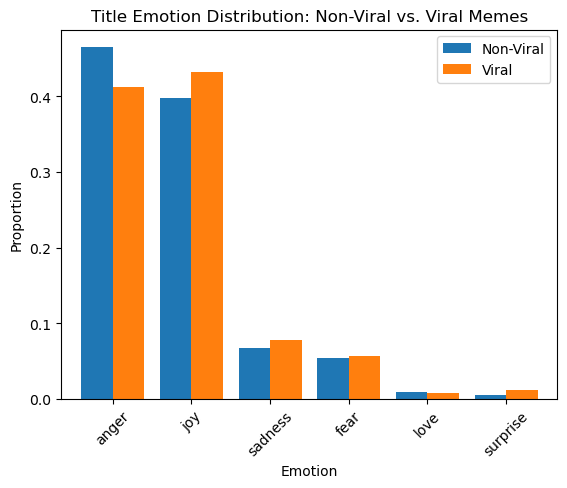

<Figure size 1400x700 with 0 Axes>

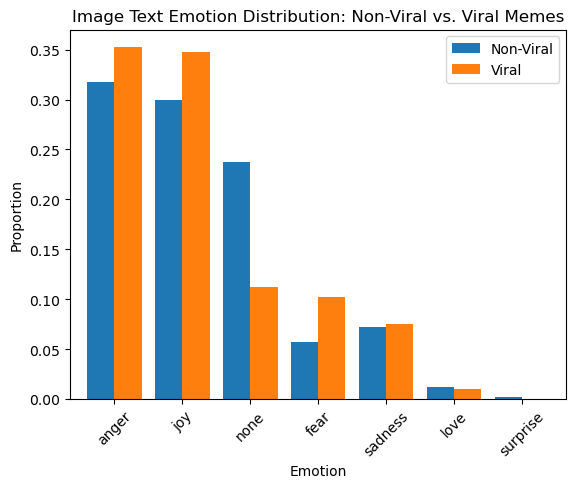

In [8]:
import matplotlib.pyplot as plt

# Plot the distributions
def plot_emotion_distribution(n_emotion_dist, v_emotion_dist, title):
    plt.figure(figsize=(14, 7))
    
    # Combine the distributions into a DataFrame for easier plotting
    emotion_dist_df = pd.DataFrame({
        'Non-Viral': n_emotion_dist,
        'Viral': v_emotion_dist
    }).fillna(0)
    
    # Sort by the sum of the values in descending order
    emotion_dist_df = emotion_dist_df.loc[emotion_dist_df.sum(axis=1).sort_values(ascending=False).index]
    
    emotion_dist_df.plot(kind='bar', width=0.8)
    plt.title(title)
    plt.xlabel('Emotion')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    plt.show()

plot_emotion_distribution(n_title_emotion_dist, v_title_emotion_dist, 'Title Emotion Distribution: Non-Viral vs. Viral Memes')
plot_emotion_distribution(n_image_emotion_dist, v_image_emotion_dist, 'Image Text Emotion Distribution: Non-Viral vs. Viral Memes')

## Import the CSV Files

In [29]:
import pandas as pd

# Load the CSV files
non_viral_df = pd.read_csv('non_viral_memes_cleaned.csv')
viral_df = pd.read_csv('top_memes_cleaned.csv')

# Extract URLs from the CSV files
non_viral_urls = non_viral_df['url'].tolist()
viral_urls = viral_df['url'].tolist()

print(f"Non-viral URLs: {non_viral_urls[:5]}")
print(f"Viral URLs: {viral_urls[:5]}")


Non-viral URLs: ['https://i.redd.it/86sheg1ggc9d1.png', 'https://i.redd.it/pddbqx3cfc9d1.png', 'https://i.redd.it/hhj740o9ec9d1.jpeg', 'https://i.redd.it/5lnglenxdc9d1.jpeg', 'https://i.redd.it/945rybapcc9d1.jpeg']
Viral URLs: ['https://i.redd.it/70zdjiilli351.jpg', 'https://i.redd.it/g4vm7de3q4j51.jpg', 'https://i.redd.it/x4s2e60m7vm41.jpg', 'https://i.redd.it/ttfhavjmd1x51.png', 'https://i.redd.it/cul580390k661.jpg']


## Define the Download Function

In [31]:
import os
import requests
from PIL import Image
from io import BytesIO

# Function to download image from URL and save to disk
def download_image_direct(url, save_dir, index):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an HTTPError for bad responses
        
        # Open the image and save it to the specified directory
        img = Image.open(BytesIO(response.content))
        img_format = img.format.lower()
        file_name = os.path.join(save_dir, f"image_{index}.{img_format}")
        img.save(file_name)
        print(f"Image saved to {file_name}")
        return file_name
    except Exception as e:
        print(f"Error downloading image from {url}: {e}")
        return None


## Save the Images

In [33]:
# Create directories for viral and non-viral images
non_viral_dir = 'D:/non_viral_images'
viral_dir = 'D:/viral_images'
os.makedirs(non_viral_dir, exist_ok=True)
os.makedirs(viral_dir, exist_ok=True)

# Download non-viral images
for i, url in enumerate(non_viral_urls):
    download_image_direct(url, non_viral_dir, i)

# Download viral images
for i, url in enumerate(viral_urls):
    download_image_direct(url, viral_dir, i)


Image saved to D:/non_viral_images\image_0.png
Image saved to D:/non_viral_images\image_1.png
Image saved to D:/non_viral_images\image_2.jpeg
Image saved to D:/non_viral_images\image_3.jpeg
Image saved to D:/non_viral_images\image_4.jpeg
Image saved to D:/non_viral_images\image_5.jpeg
Image saved to D:/non_viral_images\image_6.jpeg
Image saved to D:/non_viral_images\image_7.png
Image saved to D:/non_viral_images\image_8.jpeg
Image saved to D:/non_viral_images\image_9.jpeg
Image saved to D:/non_viral_images\image_10.png
Image saved to D:/non_viral_images\image_11.jpeg
Image saved to D:/non_viral_images\image_12.png
Error downloading image from https://i.redd.it/2c1mud8a5c9d1.jpeg: 404 Client Error: Not Found for url: https://i.redd.it/2c1mud8a5c9d1.jpeg
Image saved to D:/non_viral_images\image_14.jpeg
Error downloading image from https://i.redd.it/21tl8xq04c9d1.jpeg: 404 Client Error: Not Found for url: https://i.redd.it/21tl8xq04c9d1.jpeg
Image saved to D:/non_viral_images\image_16.jpe

## Load the VGG16 Model Pre-trained on ImageNet

In [39]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)


## Define Function to Extract Features

In [41]:
import os
from PIL import Image

# Function to extract features from an image
def extract_features(img_path, model):
    try:
        img = Image.open(img_path)
        img = img.resize((224, 224))  # Resize the image to match the input size of the model
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array)
        return features.flatten()
    except Exception as e:
        print(f"Error extracting features from {img_path}: {e}")
        return None


## Extract Features from Images and Save to CSV

In [50]:
# Define directories
non_viral_dir = 'D:/non_viral_images'
viral_dir = 'D:/viral_images'

# Initialize lists to hold data
image_data = []

# Extract features from non-viral images
for img_name in os.listdir(non_viral_dir):
    img_path = os.path.join(non_viral_dir, img_name)
    features = extract_features(img_path, model)
    if features is not None:
        image_data.append(['non_viral', img_name] + features.tolist())

# Extract features from viral images
for img_name in os.listdir(viral_dir):
    img_path = os.path.join(viral_dir, img_name)
    features = extract_features(img_path, model)
    if features is not None:
        image_data.append(['viral', img_name] + features.tolist())

# Convert to DataFrame
columns = ['category', 'image_name'] + [f'feature_{i}' for i in range(len(image_data[0]) - 2)]
df = pd.DataFrame(image_data, columns=columns)

# Save to CSV
df.to_csv('image_features.csv', index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data
image_features_df = pd.read_csv('image_features.csv')

# Encode the 'category' column as 0 (non_viral) and 1 (viral)
image_features_df['category'] = image_features_df['category'].apply(lambda x: 1 if x == 'viral' else 0)

# Drop the 'image_name' column as it is not needed for modeling
image_features_df.drop(columns=['image_name'], inplace=True)

# Separate features and target
X = image_features_df.drop(columns=['category'])
y = image_features_df['category']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


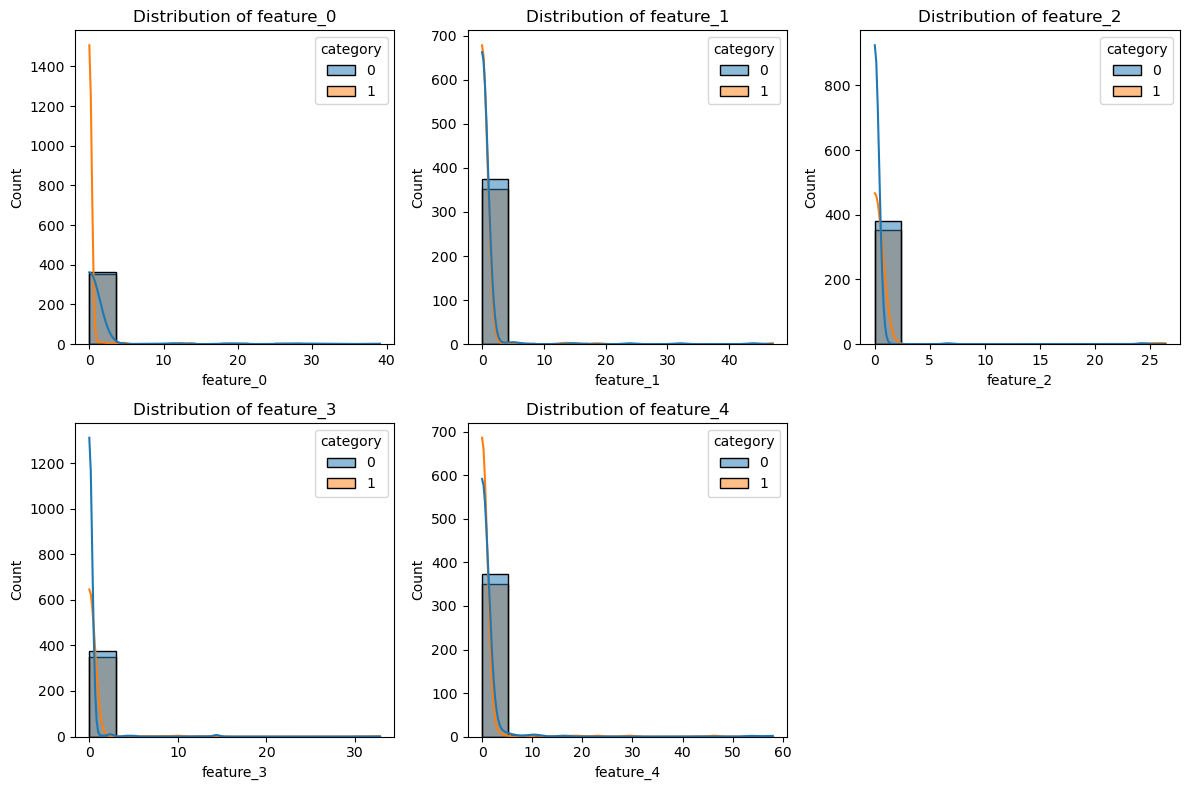

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of features
plt.figure(figsize=(12, 8))
for i in range(5):  # Plot first 5 features
    plt.subplot(2, 3, i+1)
    sns.histplot(data=image_features_df, x=f'feature_{i}', hue='category', kde=True)
    plt.title(f'Distribution of feature_{i}')
plt.tight_layout()
plt.show()


In [12]:
!pip install shap

   ---------------------------------------- 0.0/456.2 kB ? eta -:--:--
   ---------- ----------------------------- 122.9/456.2 kB 7.0 MB/s eta 0:00:01
   ------------------------------ --------- 348.2/456.2 kB 5.4 MB/s eta 0:00:01
   ---------------------------------------- 456.2/456.2 kB 4.7 MB/s eta 0:00:00


Evaluating Logistic Regression:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71        83
           1       0.63      0.69      0.66        65

    accuracy                           0.69       148
   macro avg       0.69      0.69      0.69       148
weighted avg       0.69      0.69      0.69       148

[[57 26]
 [20 45]]
ROC AUC: 0.7620

Evaluating Random Forest:
              precision    recall  f1-score   support

           0       0.72      0.73      0.73        83
           1       0.65      0.63      0.64        65

    accuracy                           0.69       148
   macro avg       0.68      0.68      0.68       148
weighted avg       0.69      0.69      0.69       148

[[61 22]
 [24 41]]
ROC AUC: 0.7670

Evaluating SVM:
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        83
           1       0.62      0.77      0.69        65

    accuracy                        

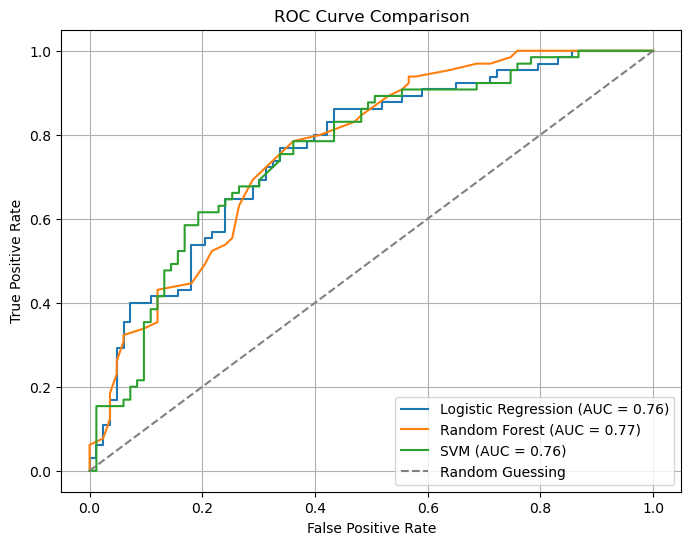

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Train a logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Train a random forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Train an SVM model
svm = SVC(probability=True)
svm.fit(X_train, y_train)

# Evaluate models
models = {'Logistic Regression': log_reg, 'Random Forest': rf, 'SVM': svm}
plt.figure(figsize=(8, 6))

for name, model in models.items():
    print(f"Evaluating {name}:")
    
    # Predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Classification report and confusion matrix
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    # ROC AUC calculation
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC: {roc_auc:.4f}")
    print()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()
